# Predictive model

In [1]:
import os; os.chdir("/home/students/s265780/ai4Trucks/")

In [2]:
from inspect_tables import read_data, overview
import re
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from dataset_generator import fornitori, binder_dt, failure_list, get_timeseries
idx = pd.IndexSlice

## Primo approccio esplorativo

Predizione di guasto su un Dataset sintetico che assuma tutte le fatture associate a un unico veicolo. Ogni fattura viene presentata al modello con un periodo $\Delta t$ di misiurazioni antecedente al guasto.
- $\Delta t$ viene posto a **1 mese**
- I dati sono al momento aggregati per ottenere **1 sample** al giorno (questa fase necessiterà di feature engineering)

Predire:
 1. Un guasto preso singolarmente (es. il più numeroso)
 2. Tutte le categorie insieme (i.e. predire una rottura qualsiasi)
 3. Modello multiclasse
 
 Modelli da testare:
  - XGBoost
  - Random Forest
  - LSTM
  - ...

In [3]:
dt=7

## Selezione Fatture

Da queste fatture vogliamo eliminare tutte quelle che hanno una fattura dello stesso tipo su quel veicolo entro un periodo di **7 giorni**

Numero di fatture totali: 208 (considerate: 150)


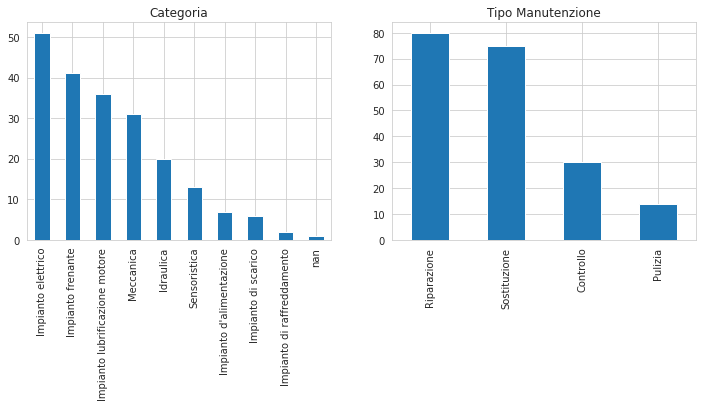

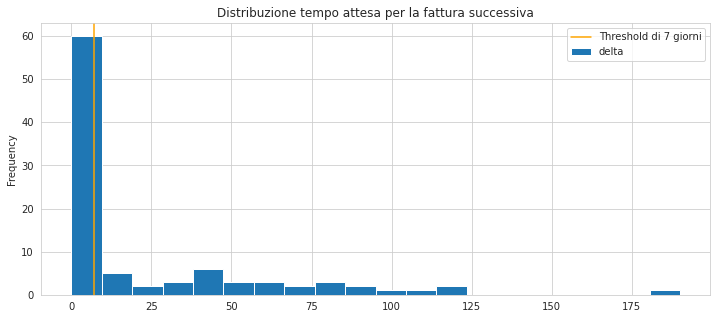

In [5]:
kept_fatture = failure_list(dt=7, verbose=True)

⚠️ Valutare se considerare solo alcune di queste tipologie di manutenzione

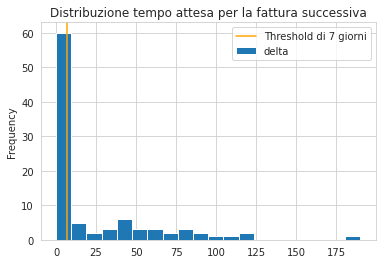

In [105]:
care_category = True
cat_fatture = cat_fatture.reset_index()

cat_fatture['delta'] = np.inf
# idx = pd.IndexSlice

if care_category:
    cat_fatture = cat_fatture.set_index(["Targa", "Categoria"]).sort_values(by="Data").sort_index()
    
    for ix in cat_fatture.index:
        cat_fatture.loc[ idx[ix], 'delta'] = cat_fatture.loc[idx[ix], 'Data' ].diff().dt.days
else:
    cat_fatture = cat_fatture.set_index(["Targa", "Data"]).sort_index()
    for plate, gp in cat_fatture.groupby("Targa"):
        cat_fatture.loc[idx[plate], "delta"] = gp.assign(date=gp.index.get_level_values("Data")).date.diff().dt.days
        
nbins = 20
d = cat_fatture.reset_index().delta.plot(kind="hist", bins=nbins, title="Distribuzione tempo attesa per la fattura successiva")  
# d.step(range(0, cat_fatture.delta.max(), nbins), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
d.axvline(dt,c="orange", label=f"Threshold di {dt} giorni")
plt.legend()
kept_fatture = cat_fatture[cat_fatture.delta.isna()|(cat_fatture.delta >= dt)]

⚠️ **Il mese considerato non deve contenere altre rotture**
Tutte le fatture (di qualsiasi tipologia) che avvengono prima di $\Delta t$ dalla rottura precedente velgono ulteriormente rimosse.

**Assunzione:** Le fatture dello stesso giorno ma di tipologia diversa vengono per il momento mantenute, nel caso del modello a classe singola se ne potrebbe considerare solo una per ogni data

## Costruzione Dataset

A partire dai dati dei 3 fornitori principali, si possono definire le serie temporali che tengano informazioni su, min, max, media, count, percentili:

|                     | Movimatica     | Scania            |  Visirun   |
| -----------         | :---------:    | :---------:       | :------:   |
| **odometro**        | odometer       | Odometer          | odometer   |
| **velocità**        | position_speed | AverageSpeed      | speed      |
| **tempo attività**  | engineHours    | EngineRunningTime | workMinutes|

 - Aggregation **giornaliera**
 - Nel caso di più fornitori: merge
 - Feature selection con pearson-correlation (> $thr$)

| Movimatica: (30678, 5) |


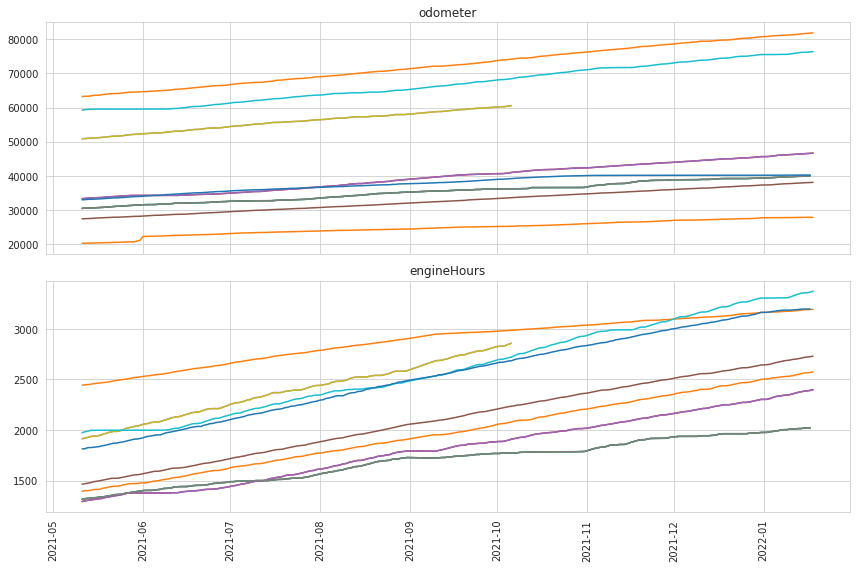

In [7]:
data_mov = binder_dt("Movimatica", fornitori.Movimatica, debug=True)

| Visirun: (12484, 6) |


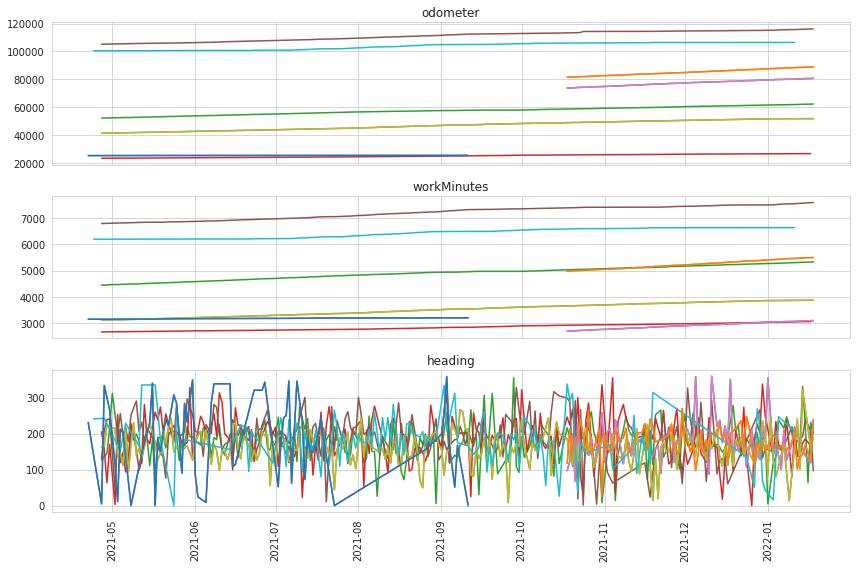

In [8]:
df_vis = binder_dt("Visirun", curr_f=fornitori.Visirun, debug=True)

---
## Alternative idea

In [ ]:
df = data_mov.set_index(["plate"]).sort_values(by=["plate", "timestamp"])
df['d_odometer'] = np.NaN
df['d_enginehours'] = np.NaN
df['timedelta'] = np.NaN

for ix in df.index.unique():
    df.loc[ idx[ix], 'd_odometer'] = df.loc[idx[ix], 'odometer' ].diff()
    df.loc[ idx[ix], 'd_enginehours'] = df.loc[idx[ix], 'engineHours' ].diff()
    df.loc[ idx[ix], 'timedelta'] = df.loc[idx[ix], 'timestamp' ].diff().dt.total_seconds() / 3600


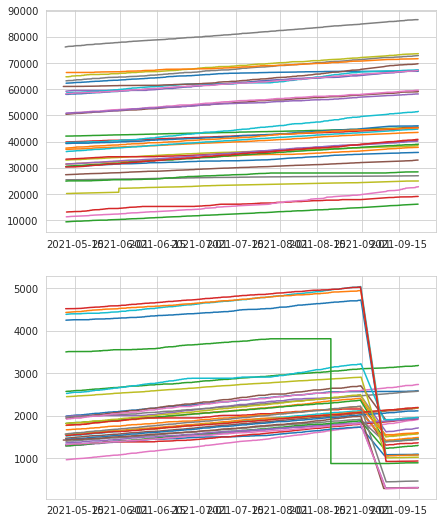

In [225]:
fig, ax = plt.subplots(2, 1, figsize= (7,9))
for ix in df.index.unique():
    ax[0].plot("timestamp","odometer", data = df.loc[idx[ix], :])
    ax[1].plot("timestamp","engineHours_2", data = df.loc[idx[ix], :])    

---
## Feature Engineering and Selection

In [9]:
dataset.set_index(["plate", "date"]).drop(["any_failure", "attended_failure", "RUL"], axis=1)

odometer_mean  odometer_std  odometer_min  odometer_max  \
plate   date                                                            
FV903SK 0      62300.000000      0.000000       62300.0       62300.0   
        1      62348.000000      0.000000       62348.0       62348.0   
        2      62382.000000     45.738387       62348.0       62434.0   
        3      62479.500000     53.033009       62442.0       62517.0   
        4      62560.000000     45.254834       62528.0       62592.0   
...                     ...           ...           ...           ...   
ZB478AN 101    37871.875000     39.840530       37835.0       37940.0   
        102    37940.000000      0.000000       37940.0       37940.0   
        103    37940.000000      0.000000       37940.0       37940.0   
        104    38040.222222     48.958599       37965.0       38082.0   
        105    38151.400000     42.506470       38122.0       38223.0   

              odometer_count  odometer_median  position_speed_mean  \
plate   date                                                         
FV903SK 0                  1          62300.0             0.000000   
        1                  1          62348.0             1.000000   
        2                  3          62364.0            10.000000   
        3                  2          62479.5             3.000000   
        4                  2          62560.0             0.000000   
...                      ...              ...                  ...   
ZB478AN 101                8          37852.5             6.000000   
        102                1          37940.0             4.000000   
        103                1          37940.0             0.000000   
        104                9          38057.0             1.777778   
        105                5          38128.0             0.800000   

              position_speed_std  position_speed_min  position_speed_max  \
plate   date                                                               
FV903SK 0               0.000000                 0.0                 0.0   
        1               0.000000                 1.0                 1.0   
        2              17.320508                 0.0                30.0   
        3               4.242641                 0.0                 6.0   
        4               0.000000                 0.0                 0.0   
...                          ...                 ...                 ...   
ZB478AN 101            12.671678                 0.0                37.0   
        102             0.000000                 4.0                 4.0   
        103             0.000000                 0.0                 0.0   
        104             1.641476                 0.0                 4.0   
        105             1.788854                 0.0                 4.0   

              position_speed_count  position_speed_median  engineHours_mean  \
plate   date                                                                  
FV903SK 0                        1                    0.0       1986.000000   
        1                        1                    1.0       1992.000000   
        2                        3                    0.0       1995.333333   
        3                        2                    3.0       2002.500000   
        4                        2                    0.0       2008.500000   
...                            ...                    ...               ...   
ZB478AN 101                      8                    1.0       4967.750000   
        102                      1                    4.0       4971.000000   
        103                      1                    0.0       4971.000000   
        104                      9                    2.0       4977.777778   
        105                      5                    0.0       4984.400000   

              engineHours_std  engineHours_min  engineHours_max  \
plate   date                                                      
FV

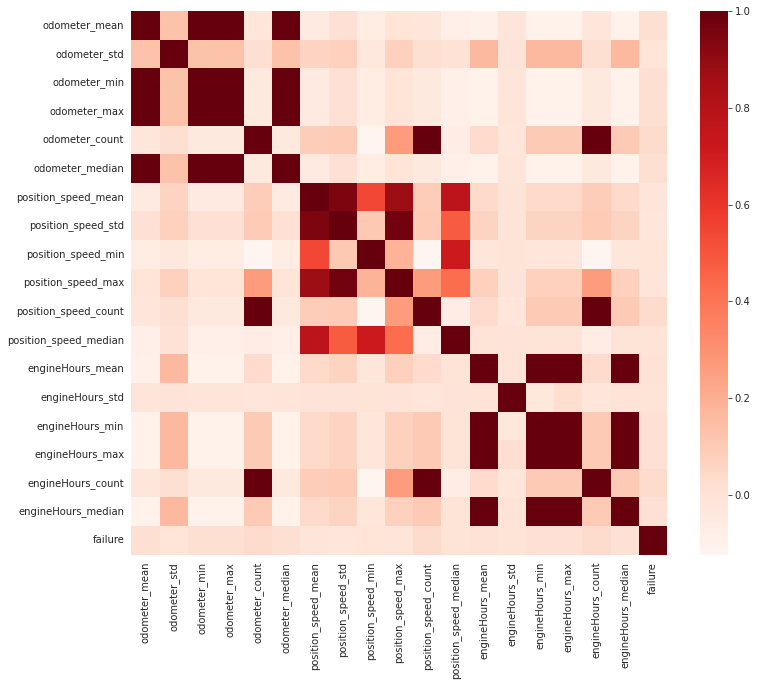

In [150]:
plt.figure(figsize=(12,10))

failures = data_mov.index.isin(df_fatture.set_index(["Targa", "Data"]).index.unique())
corr = data_mov.assign(failure=failures).corr()

sns.heatmap(corr, cmap=plt.cm.Reds)
plt.show()

In [158]:
keep = np.triu(np.ones(corr.shape)).astype('bool').reshape(corr.size)
melt = corr.stack()[keep]
melt

odometer_mean       odometer_mean         1.000000
                    odometer_std          0.131299
                    odometer_min          0.999999
                    odometer_max          0.999999
                    odometer_count       -0.019109
                                            ...   
engineHours_count   engineHours_median    0.102817
                    failure               0.031167
engineHours_median  engineHours_median    1.000000
                    failure               0.010071
failure             failure               1.000000
Length: 190, dtype: float64

---

In [3]:
dataset = get_timeseries(int_idx=False)
dataset

Numero di fatture considerate: 55
Eliminati 1272 record anomali antecedenti al 2021 (in date 03/10/2020)


,plate,date,odometer_mean,odometer_std,odometer_min,odometer_max,odometer_count,odometer_median,position_speed_mean,position_speed_std,position_speed_min,position_speed_max,position_speed_count,position_speed_median,engineHours_mean,engineHours_std,engineHours_min,engineHours_max,engineHours_count,engineHours_median,any_failure,attended_failure,RUL
0,FV903SK,0,62300.000000,0.000000,62300.0,62300.0,1,62300.0,0.000000,0.000000,0.0,0.0,1,0.0,1986.000000,0.000000,1986.0,1986.0,1,1986.0,0.0,0.0,112.0
1,FV903SK,1,62348.000000,0.000000,62348.0,62348.0,1,62348.0,1.000000,0.000000,1.0,1.0,1,1.0,1992.000000,0.000000,1992.0,1992.0,1,1992.0,0.0,0.0,111.0
2,FV903SK,2,62382.000000,45.738387,62348.0,62434.0,3,62364.0,10.000000,17.320508,0.0,30.0,3,0.0,1995.333333,4.163332,1992.0,2000.0,3,1994.0,0.0,0.0,110.0
3,FV903SK,3,62479.500000,53.033009,62442.0,62517.0,2,62479.5,3.000000,4.242641,0.0,6.0,2,3.0,2002.500000,3.535534,2000.0,2005.0,2,2002.5,0.0,0.0,109.0
4,FV903SK,4,62560.000000,45.254834,62528.0,62592.0,2,62560.0,0.000000,0.000000,0.0,0.0,2,0.0,2008.500000,3.535534,2006.0,2011.0,2,2008.5,0.0,0.0,108.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4557,ZB478AN,101,37871.875000,39.840530,37835.0,37940.0,8,37852.5,6.000000,12.671678,0.0,37.0,8,1.0,4967.750000,2.121320,4965.0,4971.0,8,4967.5,0.0,1.0,4.0
4558,ZB478AN,102,37940.000000,0.000000,37940.0,37940.0,1,37940.0,4.000000,0.000000,4.0,4.0,1,4.0,4971.000000,0.000000,4971.0,4971.0,1,4971.0,0.0,1.0,3.0
4559,ZB478AN,103,37940.000000,0.000000,37940.0,37940.0,1,37940.0,0.000000,0.000000,0.0,0.0,1,0.0,4971.000000,0.000000,4971.0,4971.0,1,4971.0,0.0,1.0,2.0
4560,ZB478AN,104,38040.222222,48.958599,37965.0,38082.0,9,38057.0,1.777778,1.641476,0.0,4.0,9,2.0,4977.777778,2.773886,4973.0,4980.0,9,4979.0,0.0,1.0,1.0


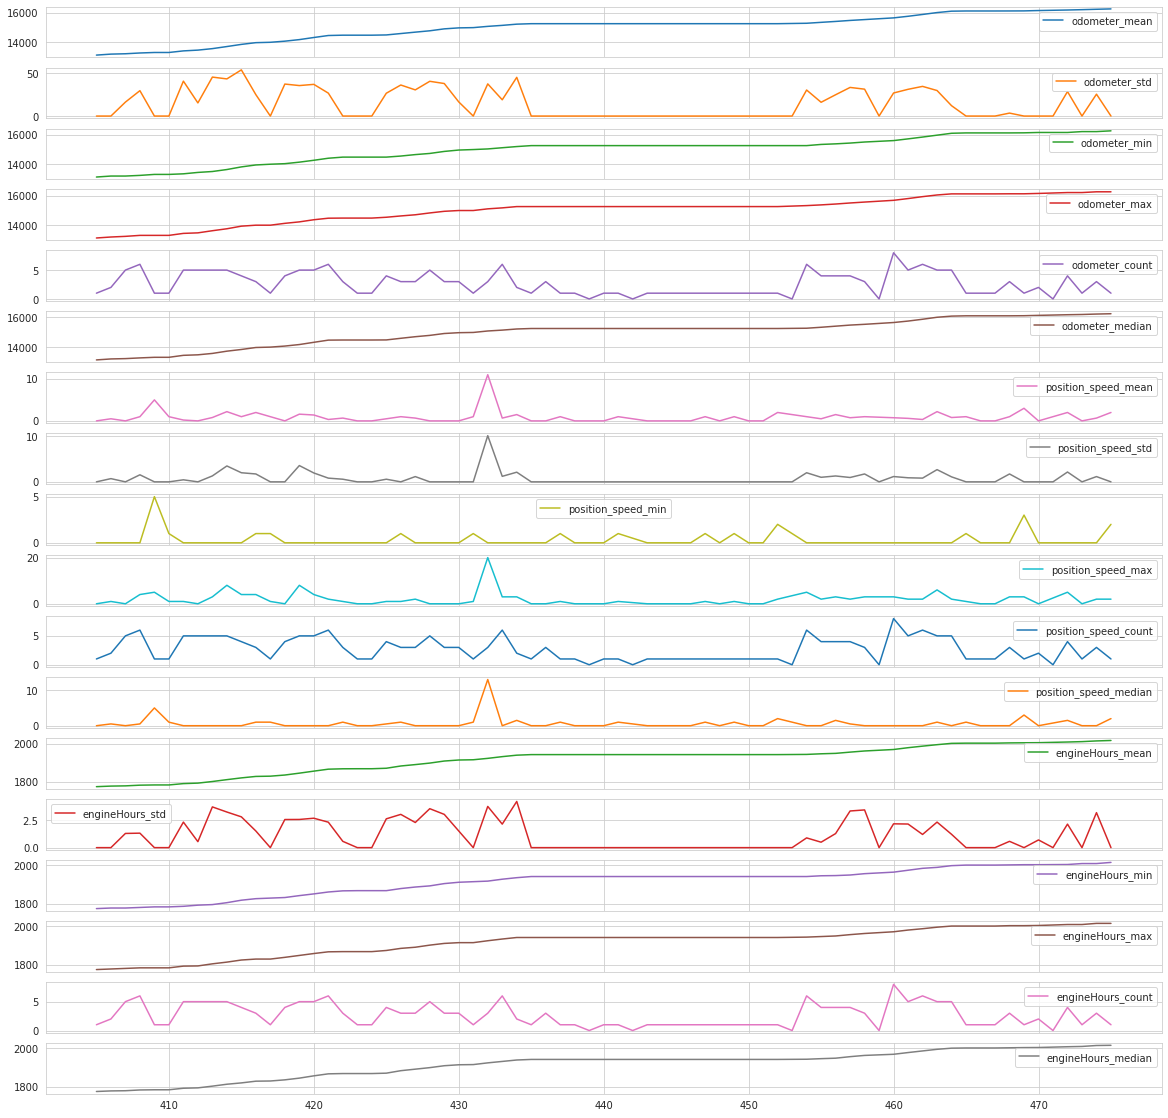

In [6]:
engine_id3 = dataset[dataset['plate'] == dataset.plate.unique()[3]]
engine_id3_50cycleWindow = engine_id3[engine_id3['RUL'] <= engine_id3['RUL'].min() + 50]
cols1 = ["odometer_mean", "odometer_std", "odometer_min", "odometer_max", "odometer_count", "odometer_median", "position_speed_mean", "position_speed_std", "position_speed_min", "position_speed_max", "position_speed_count", "position_speed_median", "engineHours_mean", "engineHours_std", "engineHours_min", "engineHours_max", "engineHours_count", "engineHours_median"]

ax1 = engine_id3_50cycleWindow[cols1].plot(subplots=True, sharex=True, figsize=(20,20))

# ML Model

In [ ]:
from pytorch_lightning import Train

In [159]:
import torch
from easydict import EasyDict as ed
from torch import nn
import pytorch_lightning as pl
from dataset_generator import get_timeseries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from dataset_generator import get_timeseries

# Paper (Vision paper)
_a sort of review_

- Introduction
- **Related works** (P.M., industry 4.0, LSTM)
- Preprocessing
    - Data integration (Fornitori con unità di misura, semantica, ecc.)
- ? Discussion on Data (tipolgia truck, mezzi satellite)
- Ideas of predictive models
    - Design assuming to have better data
- Discussion

In [158]:
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers.csv_logs import CSVLogger
from lstm_model import truckLSTM

seed_everything(1)

csv_logger = CSVLogger('./logs', name='lstm', version='0'),

trainer = Trainer(
    max_epochs=hparams.max_epochs,
    logger=csv_logger,
    gpus=0,
)

model = truckLSTM(hparams)


trainer.fit(model)

Global seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Numero di fatture considerate: 55
Eliminati 1272 record anomali antecedenti al 2021 (in date 03/10/2020)


/home/students/s265780/.local/lib/python3.7/site-packages/pytorch_lightning/loggers/csv_logs.py:58: UserWarning: Experiment logs directory ./logs/lstm/0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  f"Experiment logs directory {self.log_dir} exists and is not empty."

  | Name      | Type              | Params
------------------------------------------------
0 | criterion | BCEWithLogitsLoss | 0     
1 | lstm      | LSTM              | 128 K 
2 | linear    | Linear            | 101   
------------------------------------------------
128 K     Trainable params
0         Non-trainable params
128 K     Total params
0.516     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 1


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/students/s265780/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [4]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [5]:
logs = pd.read_csv("logs/lstm/0/metrics.csv")
logs = logs[logs.index < 2266]
logs

,train_loss_step,train_acc_step,epoch,step,val_loss_step,val_acc_step,val_loss_epoch,val_acc_epoch,train_loss_epoch,train_acc_epoch
0,NaN,0.0,0.0,49,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0.0,0.0,99,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,0.0,0.0,149,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,0.0,0.0,199,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1714,NaN,NaN,NaN,1617,NaN,0.0,NaN,NaN,NaN,NaN
1715,NaN,NaN,NaN,1618,NaN,0.0,NaN,NaN,NaN,NaN
1716,NaN,NaN,NaN,1619,NaN,0.0,NaN,NaN,NaN,NaN
1717,NaN,NaN,14.0,3494,NaN,NaN,NaN,0.0,NaN,NaN


/home/students/s265780/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation
/home/students/s265780/.local/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


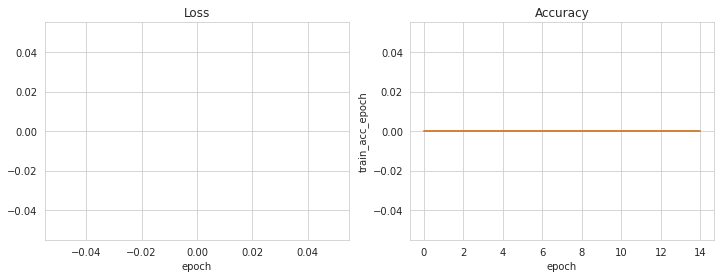

In [6]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
sns.lineplot(data=logs, x="epoch", y="train_loss_epoch", ax=ax[0])
sns.lineplot(data=logs, x="epoch", y="val_loss_epoch", ax=ax[0])
ax[0].set_title("Loss")

sns.lineplot(data=logs, x="epoch", y="train_acc_epoch", ax=ax[1])
sns.lineplot(data=logs, x="epoch", y="val_acc_epoch", ax=ax[1])
ax[1].set_title("Accuracy")
plt.show()

## Idea

Remove trucks without failures...